# Data Analysis 2 - ECBS5142 - Assignment 1

In [1]:
%%capture
!pip install -r requirements.txt;

In [2]:
# import libs
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

warnings.filterwarnings("ignore")

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# read the data from the csv file
all_df = pd.read_csv('morg-2014-emp.csv')
all_df.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


In [5]:
# Filter the data for occ2012 between 1010 and 1107
# comp_sample = all_df[(all_df['occ2012'] >= 1010) & (all_df['occ2012'] <= 1107)]
comp_sample = all_df[(all_df['occ2012'] >= 7700) & (all_df['occ2012'] <= 8965)]
#drop the all_df
del(all_df)

In [6]:
# Add a column 'hourly_wage' to the DataFrame
comp_sample['hourly_wage'] = comp_sample['earnwke'] / comp_sample['uhours']
np.round(comp_sample['hourly_wage'], decimals=2)

2         18.17
3         19.23
59         8.65
75        23.00
81        25.00
          ...  
149240    27.50
149269    36.00
149271    14.00
149285    12.99
149293    13.80
Name: hourly_wage, Length: 9205, dtype: float64

In [7]:
# add column female to have boolean for male or female
comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)

In [8]:
# Map the education levels based on 'grade92'
edu_level_dict = {
    31: 'Less than 1st grade',
    32: '1st - 4th grade',
    33: '5th or 6th',
    34: '7th or 8th',
    35: '9th',
    36: '10th',
    37: '11th',
    38: '12th grade NO DIPLOMA',
    39: 'High school graduate, diploma or GED',
    40: 'Some college but no degree',
    41: 'Associate degree -- occupational/vocational',
    42: 'Associate degree -- academic program',
    43: "Bachelor's degree",
    44: "Master's degree",
    45: 'Professional school degree',
    46: 'Doctorate degree'
}
comp_sample['edu_level'] = comp_sample['grade92'].map(edu_level_dict)

In [9]:
# Add the sex_text column for descriptive values
comp_sample['sex_text'] = comp_sample['female'].apply(lambda x: '[1] female' if x == 1 else '[0] male')

In [10]:
# Add the ln_wage column
comp_sample['ln_wage'] = np.log(comp_sample['hourly_wage'])

In [11]:
# Describe the wages
comp_sample.loc[:, ["earnwke", "uhours", "hourly_wage", "ln_wage"]].describe()

,earnwke,uhours,hourly_wage,ln_wage
count,9205.000000,9205.000000,9205.000000,9205.000000
mean,740.690005,40.739598,17.862682,2.760134
std,438.660123,7.481636,9.639406,0.512273
min,1.000000,2.000000,0.016667,-4.094345
25%,450.000000,40.000000,11.450000,2.437990
50%,636.500000,40.000000,15.384500,2.733361
75%,910.000000,40.000000,21.634500,3.074289
max,2884.610000,99.000000,192.307333,5.259095


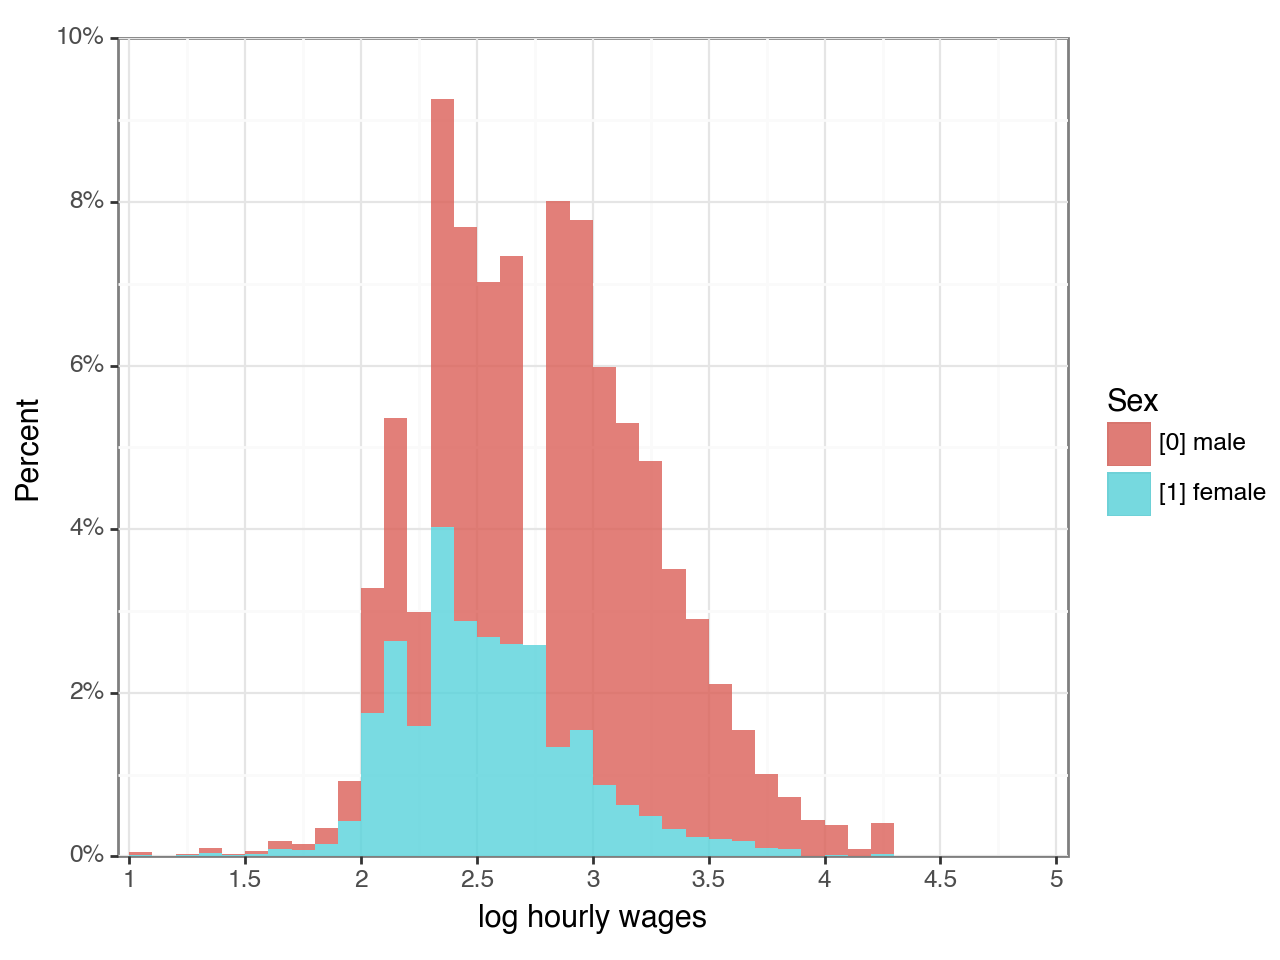

<Figure Size: (640 x 480)>

In [12]:
(
    ggplot(comp_sample, aes(x="ln_wage", y="stat(count)/sum(stat(count))", fill='factor(sex_text)'))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent", fill="Sex")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

## The unconditional gender gap

Here we will calculate the mean hourly wage of male and female and see the the difference in their hourly wage

In [13]:
mean_hourly_wage = comp_sample.groupby('female')['hourly_wage'].mean()
print(f"Average male's hourly wage: {mean_hourly_wage[0]}")
print(f"Average female's hourly wage: {mean_hourly_wage[1]}")
print(f"Unconditional gender wage gap between male and female: {mean_hourly_wage[0] - mean_hourly_wage[1]}")

Average male's hourly wage: 19.4033679514815
Average female's hourly wage: 13.854848281930211
Unconditional gender wage gap between male and female: 5.548519669551288


## The gender wage gap conditioning on education level

In [14]:
comp_sample.groupby(['grade92', 'female'])['ln_wage'].mean()

grade92  female
31       0         2.541070
         1         2.307843
32       0         2.573763
         1         2.337607
33       0         2.562947
         1         2.305592
34       0         2.585240
         1         2.325521
35       0         2.568829
         1         2.369831
36       0         2.591320
         1         2.423531
37       0         2.595804
         1         2.380101
38       0         2.631603
         1         2.343322
39       0         2.836876
         1         2.536722
40       0         2.872256
         1         2.547995
41       0         2.993716
         1         2.593162
42       0         2.961451
         1         2.638193
43       0         3.068282
         1         2.822991
44       0         3.225259
         1         3.013154
45       0         3.154108
         1         3.615622
46       0         3.227144
         1         3.137098
Name: ln_wage, dtype: float64

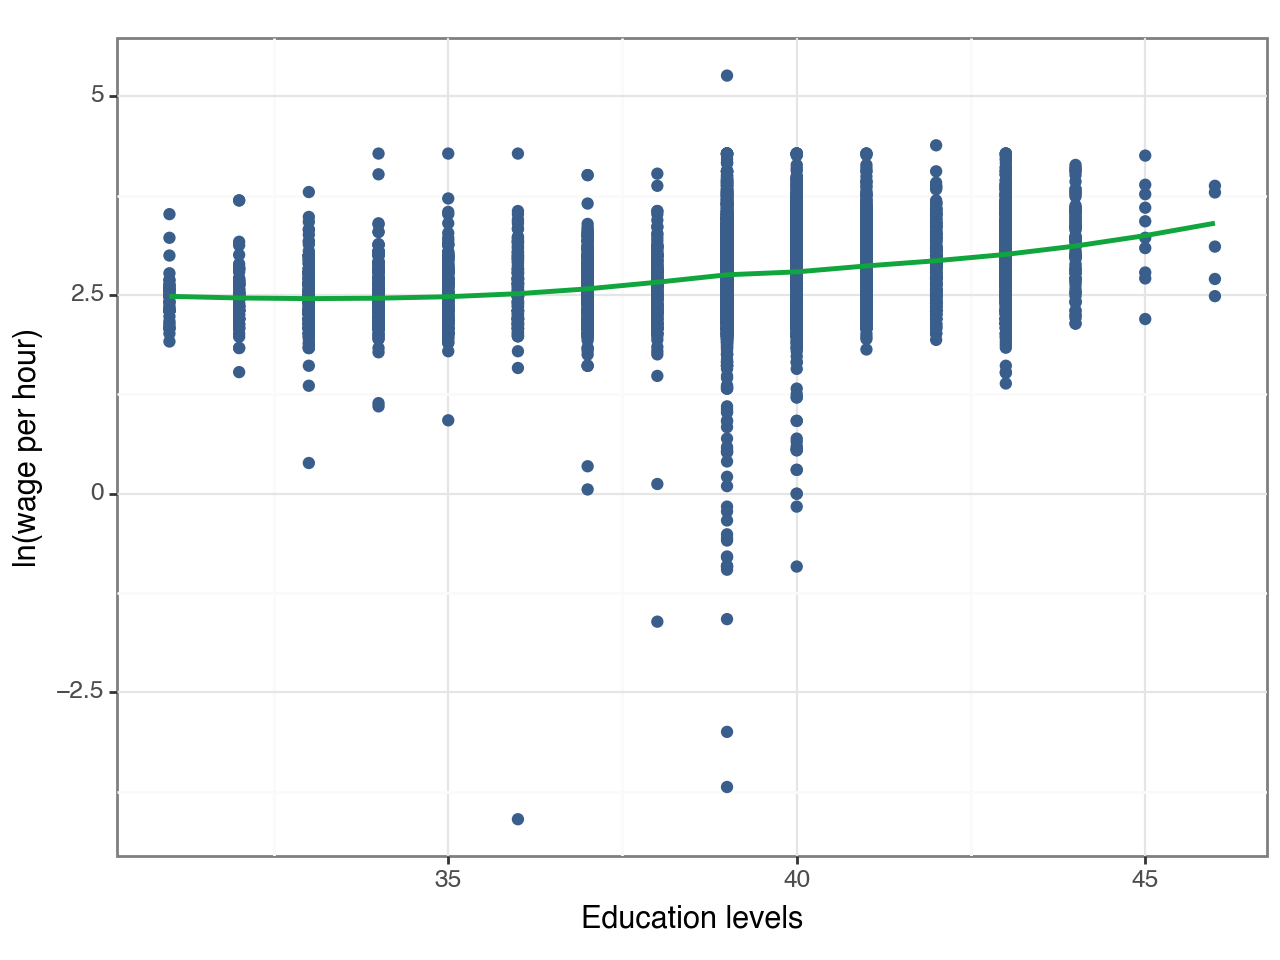

<Figure Size: (640 x 480)>

In [15]:
(
    ggplot(comp_sample, aes(x='grade92', y='ln_wage')) +
    geom_point(color=color[0]) +
    geom_smooth(method='loess', color=color[1], se=False) +
    labs(x="Education levels", y="ln(wage per hour)") +
    theme_bw()
)

In [16]:
reg1 = smf.ols(formula="hourly_wage~female+grade92", data=comp_sample).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            hourly_wage   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     827.8
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:59:14   Log-Likelihood:                -33328.
No. Observations:                9205   AIC:                         6.666e+04
Df Residuals:                    9202   BIC:                         6.668e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.6415      1.565    -12.554      0.000     -22.708     -16.575
female        -5.1733      0.176    -29.395      0.000      -5.518      -4.828
grade92        0.9937      0.040     24.627      0.000       0.915       1.073
==============================================================================
Omnibus:                     5780.665   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168587.128
Skew:                           2.535   Prob(JB):                         0.00
Kurtosis:                      23.343   Cond. No.                         687.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [17]:
reg2 = smf.ols(formula="ln_wage~female+grade92", data=comp_sample).fit(cov_type="HC1")
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     866.4
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:59:14   Log-Likelihood:                -6272.7
No. Observations:                9205   AIC:                         1.255e+04
Df Residuals:                    9202   BIC:                         1.257e+04
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7545      0.079      9.608      0.000       0.601       0.908
female        -0.2896      0.010    -27.685      0.000      -0.310      -0.269
grade92        0.0532      0.002     26.685      0.000       0.049       0.057
==============================================================================
Omnibus:                     4112.026   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107434.068
Skew:                          -1.576   Prob(JB):                         0.00
Kurtosis:                      19.437   Cond. No.                         687.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [18]:
reg3 = smf.ols(formula="ln_wage~female+lspline(grade92,[39,43])", data=comp_sample).fit(cov_type="HC1")
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     439.6
Date:                Sat, 18 Nov 2023   Prob (F-statistic):               0.00
Time:                        01:59:14   Log-Likelihood:                -6263.5
No. Observations:                9205   AIC:                         1.254e+04
Df Residuals:                    9200   BIC:                         1.257e+04
Df Model:                           4                                         
Covariance Type:                  HC1                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.0523      0.100     10.504      0.000       0.856       1.249
female                           -0.2916      0.010    -27.979      0.000      -0.312      -0.271
lspline(grade92, [39, 43])[0]     0.0453      0.003     17.230      0.000       0.040       0.050
lspline(grade92, [39, 43])[1]     0.0611      0.004     14.315      0.000       0.053       0.069
lspline(grade92, [39, 43])[2]     0.1548      0.044      3.541      0.000       0.069       0.241
==============================================================================
Omnibus:                     4111.079   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           107234.063
Skew:                          -1.575   Prob(JB):                         0.00
Kurtosis:                      19.421   Cond. No.                         954.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [19]:
stargazer = Stargazer([reg2, reg3])
stargazer.covariate_order(
    [
        "female",
        "grade92",
        "lspline(grade92, [39, 43])[0]",
        "lspline(grade92, [39, 43])[1]",
        "lspline(grade92, [39, 43])[2]",
        "Intercept",
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "grade92": "education level",
        "lspline(grade92, [39, 43])[0]": "education level <39 (High school or below)",
        "lspline(grade92, [39, 43])[1]": "education level 39–43 (Bachelor degree)",
        "lspline(grade92, [39, 43])[2]": "education level >43 (Higher education degree)",
    }
)
stargazer